In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from keras.models import Sequential
from keras.layers import Dense, LSTM ,Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


#### import data

In [2]:
data=pd.read_csv('./data/samsung.csv')
data=data.dropna().reset_index()

#### data frame 만들기

In [3]:
class sumin():
    
    def __init__(self):
        self.data = data

    @staticmethod
    def bollinger_band(data, w=20, k=2):

        data=data['Close']
        mbb = data.rolling(w).mean()
        ubb = mbb + k * data.rolling(w).std()
        lbb = mbb - k * data.rolling(w).std()
        result = np.array([data,mbb,ubb,lbb])

        df = pd.DataFrame(result).T
        df.columns = ["close", "mbb", "ubb", "lbb"]

        return df
    
    
    @staticmethod
    def moving_average(data, w=5):
        
        data=data['Close']
        ma_w=data.ewm(span=w).mean()
        ma_5=data.ewm(span=5).mean()
        ma_10=data.ewm(span=10).mean()
        ma_15=data.ewm(span=15).mean()
        ma_20=data.ewm(span=20).mean()
        ma_30=data.ewm(span=30).mean()
        ma_60=data.ewm(span=60).mean()

        result = np.array([data,ma_w,ma_5,ma_10,ma_15,ma_20,ma_30,ma_60])

        df = pd.DataFrame(result).T
        df.columns = ["close", "user_ma_{}".format(w), "ma_5", "ma_10","ma_15","ma_20","ma_30","ma_60" ]

        if w == 5:
            del df['user_ma_5']

        return df
    
    
    @staticmethod
    def macd(data, fast=12, slow=26, signal=9) :

        data=data['Close']
        fast = data.ewm(span=fast).mean() 
        slow = data.ewm(span=slow).mean() 
        macd = fast - slow 
        signal = macd.ewm(span=signal).mean() 
        osc = macd - signal 

        result = np.array([data,macd,fast,slow, signal,osc])
        df = pd.DataFrame(result).T
        df.columns = ["close", "macd", "fast", "slow","signal","osc"]

        return df
    
    @staticmethod
    def rsi(data, length=14):

        data=data['Close']
        delta = data.diff()
        delta = delta[1:]
        up, down = delta.copy(), delta.copy()
        up[up < 0.0] = 0.0
        down[down > 0.0] = 0.0

        roll_up1 = up.ewm(com=(length-1), min_periods=length).mean()
        roll_down1 = down.abs().ewm(com=(length-1), min_periods=length).mean()

        RSI_1 = roll_up1 / roll_down1
        RSI = 100.0 - (100.0 / (1.0 + RSI_1))

        df = pd.DataFrame([data,RSI]).T
        df.columns = ["close", "rsi"]

        return df
    
    
    @staticmethod
    def stochastic(data, n=15, m=5, t=3):

        high = data.High.rolling(window=n, min_periods=1).max()
        low = data.Low.rolling(window=n, min_periods=1).min()

        fast_K = ((data.Close - low) / (high - low))*100
        fast_D = fast_K.ewm(span=m).mean()
        Slow_D = fast_D.ewm(span=t).mean()

        df = pd.DataFrame([data['Close'],data['Open'],data['High'],data['Low'],fast_K,fast_D,Slow_D]).T
        df.columns = ["close",'open','high','low', "fast_K",'fast_D','slow_D']

        return df

    @staticmethod
    def roc(data,n=5):
        
        N = data['Close'].diff(n)
        D = data['Close'].shift(n)
        ROC = pd.Series(N/D,name='ROC')

        df = pd.DataFrame([data['Close'],ROC]).T
        df.columns = ["close", "roc"]
        
        return df

In [4]:
sumin=sumin()
bb=sumin.bollinger_band(data)
ma=sumin.moving_average(data)
macd=sumin.macd(data)
rsi=sumin.rsi(data)
sto=sumin.stochastic(data)
roc=sumin.roc(data)

In [5]:
bb.shape, ma.shape, macd.shape, rsi.shape, sto.shape, roc.shape

((721, 4), (721, 7), (721, 6), (721, 2), (721, 7), (721, 2))

In [6]:
data_1=pd.merge(bb,ma, how='outer', left_index=True, right_index=True)
data_1=pd.merge(data_1,macd, how='outer', left_index=True, right_index=True)
data_1=pd.merge(data_1,rsi, how='outer', left_index=True, right_index=True)
data_1=pd.merge(data_1,sto, how='outer', left_index=True, right_index=True)
data_1=pd.merge(data_1,roc, how='outer', left_index=True, right_index=True)
data_1=pd.merge(data_1, data["Close"], how='outer', left_index=True, right_index=True)

#include date
df=pd.merge(data_1, data['Date'],left_on=None, right_on=None, left_index=True, right_index=True)

In [7]:
df = df[['Date','Close','mbb','ubb','lbb','ma_5','ma_10','ma_15','ma_20','ma_30','ma_60','macd','fast','slow','signal',
                   'osc','rsi','open','high','low','fast_K','fast_D','slow_D','roc']]

In [8]:
df=df.dropna()

In [9]:
print(df.shape)
df.head()

(702, 24)


,Date,Close,mbb,ubb,lbb,ma_5,ma_10,ma_15,ma_20,ma_30,...,signal,osc,rsi,open,high,low,fast_K,fast_D,slow_D,roc
19,2017-02-15,37720.0,38415.0,40275.927895,36554.072105,37990.698549,38280.522555,38384.153558,38422.070516,38443.055695,...,43.756182,-147.316867,44.042066,37080.0,37960.0,37080.0,21.917808,34.048228,41.371132,-0.017708
20,2017-02-16,38020.0,38468.0,40211.095854,36724.904146,38000.467658,38232.443934,38335.700138,38378.445246,38406.834335,...,11.741611,-126.581872,48.808410,37800.0,38360.0,37780.0,32.191781,33.429288,37.400208,-0.009896
21,2017-02-17,37860.0,38514.0,40131.332437,36896.667563,37953.638846,38163.897615,38272.910527,38322.929469,38360.982816,...,-17.409180,-115.527689,46.531958,37560.0,38040.0,37280.0,26.712329,31.190003,34.295105,-0.013034
22,2017-02-20,38660.0,38573.0,40115.889975,37030.110025,38189.113546,38254.999775,38323.649182,38358.600947,38385.579585,...,-32.223851,-58.821431,57.264594,38220.0,38780.0,38160.0,56.028369,39.470196,36.882650,0.018440
23,2017-02-21,38940.0,38660.0,40067.169612,37252.830388,38439.423900,38380.562116,38403.950782,38419.484461,38430.390436,...,-33.421788,-4.763464,60.270516,38540.0,39560.0,38420.0,72.093023,50.345118,43.613884,0.036189


#### 상관계수 확인후 변수 삭제

In [10]:
df[['Close','mbb','ubb','lbb','ma_5','ma_10','ma_15','ma_20','ma_30','ma_60',
    'macd','fast','slow','signal','osc','rsi','open','high','low','fast_K','fast_D','slow_D','roc']].corr()

,Close,mbb,ubb,lbb,ma_5,ma_10,ma_15,ma_20,ma_30,ma_60,...,signal,osc,rsi,open,high,low,fast_K,fast_D,slow_D,roc
Close,1.000000,0.911408,0.909296,0.866577,0.987769,0.970119,0.953370,0.937534,0.908134,0.830153,...,0.476373,0.165553,0.405551,0.989702,0.995017,0.995938,0.301771,0.339666,0.343757,0.224814
mbb,0.911408,1.000000,0.979341,0.972091,0.948367,0.975816,0.989684,0.994875,0.991240,0.943675,...,0.301765,-0.204676,0.018511,0.919914,0.921643,0.915811,-0.079565,-0.036008,-0.009184,-0.094626
ubb,0.909296,0.979341,1.000000,0.904567,0.943601,0.966365,0.976636,0.979640,0.974345,0.928694,...,0.311337,-0.154547,0.047042,0.916173,0.919238,0.912609,-0.059553,-0.010463,0.017591,-0.078246
lbb,0.866577,0.972091,0.904567,1.000000,0.904698,0.936157,0.953480,0.960938,0.959418,0.912100,...,0.275005,-0.252216,-0.015551,0.876532,0.876621,0.872017,-0.098656,-0.063776,-0.039772,-0.108720
ma_5,0.987769,0.948367,0.943601,0.904698,1.000000,0.993933,0.982506,0.969546,0.942896,0.866928,...,0.474967,0.072739,0.302808,0.989488,0.991258,0.990108,0.184976,0.263891,0.289218,0.092887
ma_10,0.970119,0.975816,0.966365,0.936157,0.993933,1.000000,0.996642,0.989146,0.969124,0.900811,...,0.432382,-0.027382,0.204889,0.974890,0.976570,0.973736,0.088877,0.165689,0.196828,0.008594
ma_15,0.953370,0.989684,0.976636,0.953480,0.982506,0.996642,1.000000,0.997747,0.985012,0.926875,...,0.374476,-0.086130,0.131762,0.959595,0.961390,0.957211,0.026796,0.092078,0.121761,-0.032131
ma_20,0.937534,0.994875,0.979640,0.960938,0.969546,0.989146,0.997747,1.000000,0.994163,0.947050,...,0.315831,-0.118023,0.075722,0.944609,0.946583,0.941250,-0.015090,0.038690,0.065265,-0.055003
ma_30,0.908134,0.991240,0.974345,0.959418,0.942896,0.969124,0.985012,0.994163,1.000000,0.974543,...,0.212889,-0.141801,-0.004005,0.916062,0.918509,0.911245,-0.066806,-0.031039,-0.010591,-0.078818
ma_60,0.830153,0.943675,0.928694,0.912100,0.866928,0.900811,0.926875,0.947050,0.974543,1.000000,...,0.015461,-0.132107,-0.131183,0.838652,0.842491,0.831244,-0.135810,-0.128009,-0.118460,-0.104601


In [11]:
df=df[['Close','ma_60','macd','fast','osc','rsi','fast_K','slow_D','roc']]

#### dataframe 정규화 시키기

In [12]:
df_without_date = df[df.columns]
sc = MinMaxScaler()
df_scale_without_date = sc.fit_transform(df_without_date)

In [13]:
# 날짜 제거한 데이터 프레임 생성
df_scale_without_date = pd.DataFrame(df_scale_without_date, columns=df.columns)
df_scale_without_date.columns=[i for i in df.columns]

In [14]:
print(df_scale_without_date.shape)
df_scale_without_date.head()

(702, 9)


,Close,ma_60,macd,fast,osc,rsi,fast_K,slow_D,roc
0,0.011368,0.003998,0.358005,0.005728,0.418849,0.338202,0.219178,0.380315,0.378231
1,0.024000,0.002239,0.354439,0.003283,0.434135,0.426595,0.321918,0.335974,0.417894
2,0.017263,0.000000,0.348717,0.000000,0.442284,0.384378,0.267123,0.301301,0.401960
3,0.050947,0.001100,0.361962,0.003398,0.484089,0.583417,0.560284,0.330194,0.561755
4,0.062737,0.003172,0.378676,0.008398,0.523942,0.639163,0.720930,0.405358,0.651865


#### y값 추가하여 정규화 시킨 이후 상관계수 확인

In [15]:
y = data[["Close"]]
y = y[29:]

# data start 2017-02-15 original index 19
# so y have to start after 10day. index is 29

sc_y=MinMaxScaler()
y_scale = sc.fit_transform(y)
y_scale =pd.DataFrame(y_scale)

In [16]:
df_inclue_y=pd.concat([df_scale_without_date, y_scale], axis=1).dropna()

In [17]:
df_inclue_y.head()

,Close,ma_60,macd,fast,osc,rsi,fast_K,slow_D,roc,0
0,0.011368,0.003998,0.358005,0.005728,0.418849,0.338202,0.219178,0.380315,0.378231,0.095579
1,0.024000,0.002239,0.354439,0.003283,0.434135,0.426595,0.321918,0.335974,0.417894,0.091368
2,0.017263,0.000000,0.348717,0.000000,0.442284,0.384378,0.267123,0.301301,0.401960,0.110737
3,0.050947,0.001100,0.361962,0.003398,0.484089,0.583417,0.560284,0.330194,0.561755,0.115789
4,0.062737,0.003172,0.378676,0.008398,0.523942,0.639163,0.720930,0.405358,0.651865,0.115789


In [18]:
df_inclue_y.corr()

,Close,ma_60,macd,fast,osc,rsi,fast_K,slow_D,roc,0
Close,1.000000,0.822392,0.455316,0.960371,0.142409,0.370267,0.282000,0.324941,0.194795,0.843904
ma_60,0.822392,1.000000,-0.082903,0.908517,-0.157693,-0.180613,-0.165783,-0.149578,-0.137554,0.691208
macd,0.455316,-0.082903,1.000000,0.313415,0.401214,0.822563,0.589881,0.825218,0.296624,0.383884
fast,0.960371,0.908517,0.313415,1.000000,-0.087129,0.126018,0.029927,0.136490,-0.050669,0.814407
osc,0.142409,-0.157693,0.401214,-0.087129,1.000000,0.704609,0.792074,0.740474,0.696044,0.123178
rsi,0.370267,-0.180613,0.822563,0.126018,0.704609,1.000000,0.884532,0.859089,0.696898,0.298426
fast_K,0.282000,-0.165783,0.589881,0.029927,0.792074,0.884532,1.000000,0.813673,0.755110,0.232928
slow_D,0.324941,-0.149578,0.825218,0.136490,0.740474,0.859089,0.813673,1.000000,0.465686,0.267960
roc,0.194795,-0.137554,0.296624,-0.050669,0.696044,0.696898,0.755110,0.465686,1.000000,0.138689
0,0.843904,0.691208,0.383884,0.814407,0.123178,0.298426,0.232928,0.267960,0.138689,1.000000


#### 데이터를 5일씩 묶어주기

In [19]:
d_matrix=df_scale_without_date.as_matrix()

p_result =[]
for i in range(len(df_scale_without_date)-10):
    for j in range(5):
        p_result.append(d_matrix[i+j])

C:\Users\wsm26\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [20]:
p_result=np.array(p_result)
p_result=p_result.reshape((len(d_matrix)-10,5,-1))

In [21]:
p_result[0]

array([[0.01136842, 0.00399808, 0.35800513, 0.00572765, 0.41884881,
        0.33820211, 0.21917808, 0.38031463, 0.37823095],
       [0.024     , 0.00223915, 0.35443859, 0.00328272, 0.43413501,
        0.4265952 , 0.32191781, 0.33597361, 0.41789423],
       [0.01726316, 0.        , 0.34871656, 0.        , 0.44228435,
        0.38437781, 0.26712329, 0.3013007 , 0.40195999],
       [0.05094737, 0.0011002 , 0.36196242, 0.00339821, 0.48408921,
        0.58341731, 0.56028369, 0.33019434, 0.56175475],
       [0.06273684, 0.00317186, 0.37867643, 0.00839842, 0.52394171,
        0.63916291, 0.72093023, 0.40535816, 0.65186463]])

In [22]:
p_result.shape, y_scale.shape

((692, 5, 9), (692, 1))

#### trian, text set 나눠주기

In [23]:
X_train,X_test = p_result[:int(len(p_result)*0.9)],p_result[int(len(p_result)*0.9):]
y_train,y_test = y_scale[:int(len(p_result)*0.9)], y_scale[int(len(p_result)*0.9):]

In [24]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((622, 5, 9), (70, 5, 9), (622, 1), (70, 1))

#### 모델 만들기 (LSTM 1층, 2층)

In [25]:
model = Sequential()

#1층 모델
#model.add(LSTM(units=100, input_shape=(5,9)))
#model.add(Dense(units=1))
#model.add(Dropout(0.1))


#2층 모델
model.add(LSTM(units=100, input_shape=(5,9), return_sequences=True))
model.add(Dense(units=1))
model.add(Dropout(0.1))
model.add(LSTM(units=100))
model.add(Dense(units=1))

early_stopping = EarlyStopping(patience=30)

model.compile(optimizer='rmsprop', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=300, batch_size=64, validation_split=0.3, callbacks=[early_stopping])

Train on 435 samples, validate on 187 samples
Epoch 1/300
435/435 [==============================] - 1s 3ms/step - loss: 0.0786 - val_loss: 0.0074
Epoch 2/300
435/435 [==============================] - 0s 347us/step - loss: 0.0233 - val_loss: 0.0104
Epoch 3/300
435/435 [==============================] - 0s 358us/step - loss: 0.0155 - val_loss: 0.0091
Epoch 4/300
435/435 [==============================] - 0s 379us/step - loss: 0.0166 - val_loss: 0.0079
Epoch 5/300
435/435 [==============================] - 0s 374us/step - loss: 0.0158 - val_loss: 0.0068
Epoch 6/300
435/435 [==============================] - 0s 393us/step - loss: 0.0126 - val_loss: 0.0075
Epoch 7/300
435/435 [==============================] - 0s 377us/step - loss: 0.0151 - val_loss: 0.0071
Epoch 8/300
435/435 [==============================] - 0s 384us/step - loss: 0.0124 - val_loss: 0.0104
Epoch 9/300
435/435 [==============================] - 0s 430us/step - loss: 0.0139 - val_loss: 0.0073
Epoch 10/300
435/435 [=======

#### prediction

In [26]:
predicted = model.predict(X_test)

In [27]:
len(y_test), type(y_test) , len(predicted), type(predicted)

(70, pandas.core.frame.DataFrame, 70, numpy.ndarray)

In [28]:
y_test=np.array(y_test)

#### accuracy

In [29]:
RMSE = mean_squared_error(y_test, predicted)**0.5    
print("RMSE =",RMSE)
error = y_test-predicted
print("STD = ", np.std(error))

RMSE = 0.21823781565146547
STD =  0.09809630678025721


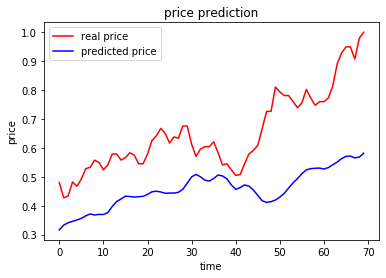

In [30]:
plt.plot(y_test, color="red", label="real price")
plt.plot(predicted, color="blue", label="predicted price")
plt.title("price prediction")
plt.xlabel("time")
plt.ylabel("price")
plt.legend()
plt.show()